# ID2214 Programming for Data Science

### Assignment 4

Authors: \
Lucas Larsson lulars@kth.se \
Mihaela Bakšić baksic@kth.se

In [11]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures, AllChem, Draw, rdmolops, Lipinski, rdMolDescriptors, Fragments
from rdkit import RDConfig
from molmass import Formula
import os
import re

In [12]:
train_data = pd.read_csv('training_smiles.csv', dtype = {'ACTIVE': int})
test_data = pd.read_csv('test_smiles.csv')

train_data.head()

,INDEX,SMILES,ACTIVE
0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0
1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0
2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0
3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0
4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0


In [13]:
train_data[['INDEX', 'ACTIVE']].groupby('ACTIVE').count()

,INDEX
ACTIVE,
0,154528
1,1730


### Feature extracting functions

In [15]:
def extract_charge(df):
  '''
    Extracts molecule charge from the mol column of the dataframe
    Returns charge series
  '''
  return df['MOL'].apply(lambda x: rdmolops.GetFormalCharge(x))


def extract_mol(df):
  '''
    Extracts molecule object from the smiles column of the dataframe
    Returns molecule series
  '''
  return df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))


def extract_num_atoms(df, atom_symbol):
  '''
    Extracts number of atoms with a given symbol from the molecule
    Returns count series
  '''

  m = Chem.MolFromSmarts(atom_symbol)
  return df['MOL'].apply(lambda x: len(x.GetSubstructMatches(m)))


def extract_fingerprints(df, size_fp=124):
  '''
    Extracts fingerprint vectors from smiles columns
    Returns a dataframe where each column is a fingerprint bit and a list of fingerprint feature names
  '''

  fingerprints = df['MOL'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=size_fp))
  fp_features = [f'fp_{i}' for i in range(size_fp)]

  fingerprints_array = [ [ fp[i] for i in range(size_fp) ] for fp in fingerprints]
  return pd.DataFrame(data=fingerprints_array, columns=fp_features), fp_features


def extract_heavy_atom_count(df):
  '''
  Extracts number of heavy atoms from the molecule
  Returns a series with the heavy atom count
  '''
  return df['MOL'].apply(lambda x: Lipinski.HeavyAtomCount(x))

def extract_NHOH(df):

  return df['MOL'].apply(lambda x: Lipinski.NHOHCount(x))


def extract_rotatable_bonds(df):
  return df['MOL'].apply(lambda x: Lipinski.NumRotatableBonds(x))


def extract_num_rings(df):
  return df['MOL'].apply(lambda x: Lipinski.RingCount(x))
  
def extract_num_aromatic_rings(df):
  return df['MOL'].apply(lambda x: Lipinski.NumAromaticRings(x))

def extract_num_saturated_rings(df):
  return df['MOL'].apply(lambda x: Lipinski.NumSaturatedRings(x))


def extract_donors_and_acceptors(df):
  '''
  Extracts number of hydrogen Acceptors and Donors respectivlly 
  Returns two seriess containing the number bondes of 'Acceptors' and 'Donors'
  '''
  acceptors = df['MOL'].apply(lambda x: Lipinski.NumHAcceptors(x))
  donors = df['MOL'].apply(lambda x: Lipinski.NumHDonors(x))
  return acceptors, donors
  

def calculate_mass(df):
  '''
  Calculates the mass of a molecule
  Returns a series with mass of molecule in dalton
  '''
  return df['MOL'].apply(lambda x: Formula(re.sub(r"-\d+","", rdMolDescriptors.CalcMolFormula(x))).mass)


def extract_Al_OOF(df):
  return df['MOL'].apply(lambda x: Fragments.fr_Al_COO(x))

def extract_Al_OH(df):
  return df['MOL'].apply(lambda x: Fragments.fr_Al_OH(x))

def extract_saturated_carbocycles(df):
  return df['MOL'].apply(lambda x: Lipinski.NumSaturatedCarbocycles(x))

def extract_saturated_heterocycles(df):
  return df['MOL'].apply(lambda x: Lipinski.NumSaturatedHeterocycles(x))


## Applying feature extraction


In [16]:
train_data['MOL'] = extract_mol(train_data)
train_data['CHARGE'] = extract_charge(train_data)
train_data['NUM_C'] = extract_num_atoms(train_data, 'C')
train_data['NUM_O'] = extract_num_atoms(train_data, 'O')
train_data['NUM_N'] = extract_num_atoms(train_data, 'N')
train_data['NUM_HEAVY'] = extract_heavy_atom_count(train_data)
train_data['MASS'] = calculate_mass(train_data)
train_data['ACCEPTORS'], train_data['DONORS'] = extract_donors_and_acceptors(train_data)
train_data['AL_OOF'] = extract_Al_OOF(train_data)
train_data['AL_OH'] = extract_Al_OH(train_data)
train_data['NUM_NHOH'] = extract_NHOH(train_data)
train_data['NUM_RINGS'] = extract_num_rings(train_data)
train_data['NUM_AROM_RINGS'] = extract_num_aromatic_rings(train_data)
train_data['NUM_SAT_RINGS'] = extract_num_saturated_rings(train_data)
train_data['NUM_ROT_BONDS'] = extract_rotatable_bonds(train_data)
train_data['NUM_HETCYCLES'] = extract_saturated_heterocycles(train_data)
train_data['NUM_CARBCYCLES'] = extract_saturated_carbocycles(train_data)


# fingerprints
size_fp = 64
fingerprints, fp_features = extract_fingerprints(train_data, size_fp)
train_data = train_data.join(fingerprints)


[19:34:01] WARNING: not removing hydrogen atom without neighbors


In [17]:
custom_features = ['CHARGE','MASS', 'NUM_C', 'NUM_O', 'NUM_N', 'NUM_HEAVY', 
                   'ACCEPTORS', 'DONORS', 'AL_OOF', 'AL_OH', 'NUM_NHOH', 
                   'NUM_RINGS', 'NUM_AROM_RINGS', 'NUM_SAT_RINGS', 'NUM_ROT_BONDS',
                   'NUM_HETCYCLES', 'NUM_CARBCYCLES']


In [18]:
train_data.head()

,INDEX,SMILES,ACTIVE,MOL,CHARGE,NUM_C,NUM_O,NUM_N,NUM_HEAVY,MASS,...,fp_54,fp_55,fp_56,fp_57,fp_58,fp_59,fp_60,fp_61,fp_62,fp_63
0,1,CC(C)N1CC(=O)C(c2nc3ccccc3[nH]2)=C1N,0,<rdkit.Chem.rdchem.Mol object at 0x7f906992f920>,0,7,1,2,19,256.303633,...,0,1,0,0,1,0,0,0,0,1
1,2,COc1ccc(-c2ccc3c(N)c(C(=O)c4ccc(OC)c(OC)c4)sc3...,0,<rdkit.Chem.rdchem.Mol object at 0x7f906992fae0>,0,4,4,1,30,420.481666,...,0,1,1,1,1,0,0,1,1,1
2,3,CCc1ccc(C(=O)COC(=O)CCc2nc(=O)c3ccccc3[nH]2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f906992f8b0>,0,7,4,0,27,364.395386,...,1,1,0,0,1,0,0,1,1,1
3,4,O=C(CN1CCOCC1)Nc1ccc(S(=O)(=O)N2CCCCCC2)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f906992f5a0>,0,12,4,3,26,381.490256,...,1,0,0,1,0,0,0,1,0,1
4,5,C=CCC(Nc1ccccc1)c1ccc(OC)c(OC)c1,0,<rdkit.Chem.rdchem.Mol object at 0x7f906992f6f0>,0,6,2,1,21,283.365594,...,1,1,0,1,0,0,0,1,0,1


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

# from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/ID2214/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Fingerprint length optimization

In [24]:
fp_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

n_estimators = [20, 40, 60, 70, 80, 100]

fp_results = []

n_runs = 30

for fp_s in fp_sizes:

  fingerprints_optim, fingerprint_features = extract_fingerprints(train_data, fp_s)

  acc_nb = 0
  f1_nb = 0
  auc_nb = 0

  acc_lr = 0
  f1_lr = 0
  auc_lr = 0

  for i in range(n_runs): # run 50 times and average the results
    # create a train test split for current iteration
    X_train, X_validation, y_train, y_validation = train_test_split(fingerprints_optim, train_data['ACTIVE'], test_size=0.3, random_state=i)

    # fit and predict
    nb = make_pipeline(StandardScaler(),GaussianNB())
    nb.fit(X_train, y_train)
    y_valid_nb = nb.predict(X_validation)

    lr = make_pipeline(StandardScaler(),LogisticRegression())
    lr.fit(X_train, y_train)
    y_valid_lr = lr.predict(X_validation)

    # store scores
    acc_nb += accuracy_score(y_validation, y_valid_nb)
    f1_nb += f1_score(y_validation, y_valid_nb)
    auc_nb += roc_auc_score(y_validation, y_valid_nb)

    acc_lr += accuracy_score(y_validation, y_valid_lr)
    f1_lr += f1_score(y_validation, y_valid_lr)
    auc_lr += roc_auc_score(y_validation, y_valid_lr)

  acc_nb /= n_runs
  f1_nb /= n_runs
  auc_nb /= n_runs

  acc_lr /= n_runs
  f1_lr /= n_runs
  auc_lr /= n_runs




  # store results for current fp size in the dataframe
  fp_results.append([fp_s, 'nb', acc_nb, f1_nb, auc_nb])
  fp_results.append([fp_s, 'lr', acc_lr, f1_lr, auc_lr])


  for n in n_estimators:

    acc_rfc = 0
    f1_rfc = 0
    auc_rfc = 0

    for i in range(n_runs): # run 50 times and average the results
      # create a train test split for current iteration
      X_train, X_validation, y_train, y_validation = train_test_split(fingerprints_optim, train_data['ACTIVE'], test_size=0.3, random_state=i)

      rfc = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=n))
      rfc.fit(X_train, y_train)
      y_valid_rfc = rfc.predict(X_validation)

      acc_rfc += accuracy_score(y_validation, y_valid_rfc)
      f1_rfc += f1_score(y_validation, y_valid_rfc)
      auc_rfc += roc_auc_score(y_validation, y_valid_rfc)

    acc_rfc /= n_runs
    f1_rfc /= n_runs
    auc_rfc /= n_runs

    fp_results.append([fp_s, f'rfc_{n}', acc_rfc, f1_rfc, auc_rfc])



rez = pd.DataFrame(data=fp_results, columns=['fp_size', 'classifier', 'acc', 'f1', 'auc'])


In [27]:
rez.to_csv('fingerprint_size_opt.csv')

rez.sort_values('auc', ascending=False).head(20)


,fp_size,classifier,acc,f1,auc
72,100,nb,0.968594,0.054286,0.530217
48,70,nb,0.968108,0.042369,0.521019
56,80,nb,0.969739,0.037367,0.515915
64,90,nb,0.977107,0.040016,0.515390
20,30,rfc_60,0.987614,0.033513,0.508923
23,30,rfc_100,0.987685,0.033494,0.508893
22,30,rfc_80,0.987620,0.033212,0.508829
19,30,rfc_40,0.987614,0.033199,0.508825
21,30,rfc_70,0.987593,0.032853,0.508727
0,10,nb,0.055258,0.022316,0.508038


In [ ]:
# Train and validation split

seed = 10
X_train, X_validation, y_train, y_validation = train_test_split(train_data.drop(['INDEX', 'SMILES', 'MOL', 'ACTIVE'], axis=1), train_data['ACTIVE'], test_size=0.3, random_state=seed)

## Custom feature selection

In order to determine the quality of custom extracted features we perform feature selection

For this we use Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()

rfc.fit(X_train[custom_features], y_train)

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)


MASS              0.297879
NUM_C             0.114970
NUM_O             0.067504
NUM_N             0.056298
NUM_HEAVY         0.098093
ACCEPTORS         0.089220
DONORS            0.029071
NUM_NHOH          0.035079
NUM_RINGS         0.030921
NUM_AROM_RINGS    0.028340
NUM_SAT_RINGS     0.017083
NUM_ROT_BONDS     0.095999
NUM_HETCYCLES     0.013526
NUM_CARBCYCLES    0.010879
dtype: float64


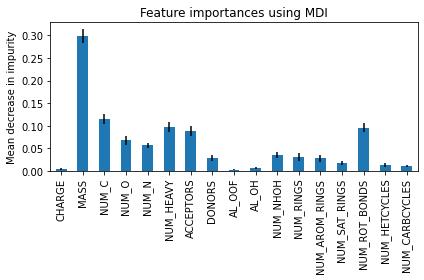

In [ ]:

forest_importances = pd.Series(importances, index=custom_features)

print(forest_importances.loc[lambda x : x > 0.01])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Baselines

- Logistic regression
- Naive Bayes
- Random Forest


In [ ]:
def train_validate_model(classifier, classifier_name, X, y, print_rez=True):

  pipe = make_pipeline(StandardScaler(), classifier)

  # perform cross validation
  y_train = []
  y_pred = []

  cv = StratifiedKFold(n_splits=6)
  for fold, (train, valid) in enumerate(cv.split(X, y)):

    pipe.fit(X.loc[train], y.loc[train])

    y_train.extend(y.loc[valid].tolist())
    y_pred.extend(pipe.predict(X.loc[valid]))

  acc= accuracy_score(y_train, y_pred)
  f1= f1_score(y_train, y_pred)

  auc = roc_auc_score(y, y_pred)

  if print_rez:
    print(f'{classifier_name} :')
    print(f'Accuracy: {acc}  F1: {f1}')
    print(f'AUC = {auc}')

  return y_train, y_pred, auc


### Fingerprint dataset


In [ ]:
seed = 10
X = train_data[fp_features]
y = train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.2, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)


In [ ]:
# Logistic Regression

lr = LogisticRegression()

print('Original dataset')
y_true, y_pred, auc = train_validate_model(lr, 'Logistic Regression', X, y)

print('SMOTE dataset')
y_true, y_pred, auc = train_validate_model(lr, 'Logistic Regression', X_smote, y_smote)


Original dataset
Logistic Regression :
Accuracy: 0.988928566857377  F1: 0.0
AUC = 0.5
SMOTE dataset
Logistic Regression :
Accuracy: 0.8498379468595126  F1: 0.3375758296657547
AUC = 0.5011460246530686


In [ ]:
# Naive Bayes

nb = GaussianNB()

print('Original dataset')
y_true, y_pred, auc = train_validate_model(nb, 'Naive Bayes Classifier', X, y)

print('SMOTE dataset')
y_true, y_pred, auc = train_validate_model(nb, 'Naive Bayes Classifier', X_smote, y_smote)


Original dataset
Naive Bayes Classifier :
Accuracy: 0.8099425309424158  F1: 0.02546433024873663
AUC = 0.5215573779322183
SMOTE dataset
Naive Bayes Classifier :
Accuracy: 0.7365625320196513  F1: 0.44122895314787697
AUC = 0.49973439459560665


In [ ]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=50)

print('Original dataset')
y_true, y_pred, auc = train_validate_model(rfc, 'Random Forest Classifier',X, y)

print('SMOTE dataset')
y_true, y_pred, auc = train_validate_model(rfc, 'Random Forest Classifier', X_smote, y_smote)

Original dataset
Random Forest Classifier :
Accuracy: 0.9889029681680298  F1: 0.02802690582959641
AUC = 0.5065470933976685
SMOTE dataset
Random Forest Classifier :
Accuracy: 0.9901365992029466  F1: 0.9696366020884173
AUC = 0.5105887848398399


### Custom features dataset

In [ ]:
seed = 10
X, y = train_data[custom_features], train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.2, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
# Logistic Regression

lr = LogisticRegression()

print('Original dataset')
y_true, y_pred, auc  = train_validate_model(lr, 'Logistic Regression',
                                                           X, y)

print('SMOTE dataset')
y_true, y_pred, auc  = train_validate_model(lr, 'Logistic Regression',
                                                           X_smote, y_smote)


Original dataset
Logistic Regression :
Accuracy: 0.9889093678403665  F1: 0.002302820955670697
AUC = 0.5005618563842967
SMOTE dataset
Logistic Regression :
Accuracy: 0.799561027433089  F1: 0.017395442288373076
AUC = 0.4839932955081922


In [ ]:
# Naive Bayes

nb = GaussianNB()

print('Original dataset')
y_true, y_pred, auc  = train_validate_model(nb, 'Naive Bayes Classifier',
                                                           X, y)

print('SMOTE dataset')
y_true, y_pred, auc  = train_validate_model(nb, 'Naive Bayes Classifier',
                                                           X_smote, y_smote)


Original dataset
Naive Bayes Classifier :
Accuracy: 0.9622867309193769  F1: 0.05363738557893047
AUC = 0.5342554900726224
SMOTE dataset
Naive Bayes Classifier :
Accuracy: 0.4121272912588374  F1: 0.04299923623243115
AUC = 0.27897286488054873


In [ ]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=50)

print('Original dataset')
y_true, y_pred, auc  = train_validate_model(rfc, 'Random Forest Classifier',
                                                           X, y)

print('SMOTE dataset')
y_true, y_pred, auc  = train_validate_model(rfc, 'Random Forest Classifier',
                                                           X_smote, y_smote)

Original dataset
Random Forest Classifier :
Accuracy: 0.9883717953640774  F1: 0.0629190304280557
AUC = 0.5171511801890553
SMOTE dataset
Random Forest Classifier :
Accuracy: 0.8380978574471643  F1: 0.1433544484391942
AUC = 0.5353697836121549


### Combined features dataset

In [ ]:
seed = 10
X, y = train_data.drop(['INDEX', 'SMILES', 'MOL', 'ACTIVE'] , axis=1), train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.2, random_state=seed)
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
# Logistic Regression

lr = LogisticRegression()

print('Original dataset')
y_true, y_pred, auc  = train_validate_model(lr, 'Logistic Regression', X, y)

print('SMOTE dataset')
y_true, y_pred, auc  = train_validate_model(lr, 'Logistic Regression', X_smote, y_smote)


Original dataset
Logistic Regression :
Train set:      Accuracy: 0.9887639422197843  F1: 0.0016246953696181967
Validation set: Accuracy: 0.988928708562652  F1: 0.0038387715930902106
AUC = 0.5009169514776702
SMOTE dataset
Logistic Regression :
Train set:      Accuracy: 0.9805929213084947  F1: 0.9404843473124631
Validation set: Accuracy: 0.9820384828704296  F1: 0.03218390804597702
AUC = 0.5099147315538063


In [ ]:
# Naive Bayes

nb = GaussianNB()

print('Original dataset')
y_true, y_pred, auc  = train_validate_model(nb, 'Naive Bayes Classifier', X, y)

print('SMOTE dataset')
y_true, y_pred, auc  = train_validate_model(nb, 'Naive Bayes Classifier', X_smote, y_smote)


Original dataset
Naive Bayes Classifier :
Train set:      Accuracy: 0.9498080087767417  F1: 0.0773109243697479
Validation set: Accuracy: 0.9499552028670165  F1: 0.07125890736342043
AUC = 0.5666616897597243
SMOTE dataset
Naive Bayes Classifier :
Train set:      Accuracy: 0.9286352640256399  F1: 0.8030782967324984
Validation set: Accuracy: 0.9286232347796408  F1: 0.011229314420803781
AUC = 0.4877108859613321


In [ ]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=50)

print('Original dataset')
y_true, y_pred, auc = train_validate_model(rfc, 'Random Forest Classifier', X, y)

print('SMOTE dataset')
y_true, y_pred, auc = train_validate_model(rfc, 'Random Forest Classifier', X_smote, y_smote)

Original dataset
Random Forest Classifier :
Train set:      Accuracy: 0.9991588955933443  F1: 0.9606837606837607
Validation set: Accuracy: 0.9890353684030889  F1: 0.019083969465648852
AUC = 0.5048112310850488
SMOTE dataset
Random Forest Classifier :
Train set:      Accuracy: 0.9997457587944344  F1: 0.9992367295015613
Validation set: Accuracy: 0.9889500405307393  F1: 0.04428044280442805
AUC = 0.5114887185106805


Note: SMOTE doesn't work well for fingerprint vector features, but improves performance on extracted features

# Model development - XGBoost

### Fingerprint dataset

In [ ]:
seed = 10
X, y = train_data[fp_features], train_data['ACTIVE']

smote = SMOTE(sampling_strategy=0.2, random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X, y)

In [ ]:
# XGBoost

n_estimators =[ 80, 90, 100]

for n in n_estimators:
  xgb = XGBClassifier(n_estimators=n, scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train))

  print(f'\nN estimators {n}')

  print('Original dataset')
  y_true, y_pred, auc  = train_validate_model(xgb, 'XGB Classifier', X, y)


  print('SMOTE dataset')
  y_true, y_pred, auc  = train_validate_model(xgb, 'XGB Classifier', X_smote, y_smote)



N estimators 80
Original dataset


ValueError: ignored

### Custom features dataset

In [ ]:
seed = 10
X_train, X_validation, y_train, y_validation = train_test_split(train_data[custom_features], train_data['ACTIVE'], test_size=0.3, random_state=seed)

smote = SMOTE(sampling_strategy=0.2, random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# XGBoost

n_estimators =[ 80, 90, 100]

for n in n_estimators:
  xgb = XGBClassifier(n_estimators=n, scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train))

  print(f'\nN estimators {n}')

  #print('Original dataset')
  y_train_pred, y_validation_pred = train_validate_model(xgb, 'XGB Classifier',
                                                            X_train, y_train, 
                                                            X_validation, y_validation)


  print('SMOTE dataset')
  y_train_pred, y_validation_pred = train_validate_model(xgb, 'XGB Classifier',
                                                            X_train_smote, y_train_smote, 
                                                            X_validation, y_validation)



N estimators 80
XGB Classifier :
Train set:      Accuracy: 0.709855549460596  F1: 0.053560777764523435
Validation set: Accuracy: 0.7088612995434959  F1: 0.048389345976851204
AUC = 0.691518659527004
SMOTE dataset
XGB Classifier :
Train set:      Accuracy: 0.3016764511009415  F1: 0.3228621161072472
Validation set: Accuracy: 0.1705917487947438  F1: 0.02492789968652038
AUC = 0.5634077349510165

N estimators 90
XGB Classifier :
Train set:      Accuracy: 0.711391479246663  F1: 0.054284002396644694
Validation set: Accuracy: 0.7103118733734375  F1: 0.048619868291999435
AUC = 0.6922520029258349
SMOTE dataset
XGB Classifier :
Train set:      Accuracy: 0.31016656651104024  F1: 0.32552183378153415
Validation set: Accuracy: 0.18010580656171338  F1: 0.025110970196575776
AUC = 0.5662974262410874

N estimators 100
XGB Classifier :
Train set:      Accuracy: 0.7139147924666301  F1: 0.05485079134952277
Validation set: Accuracy: 0.712786381671573  F1: 0.048749470114455275
AUC = 0.6915828218392261
SMOTE d

### Combined dataset

In [ ]:
seed = 10
X_train, X_validation, y_train, y_validation = train_test_split(train_data.drop(['INDEX', 'SMILES', 'MOL', 'ACTIVE'] , axis=1), train_data['ACTIVE'], test_size=0.3, random_state=seed)

smote = SMOTE(sampling_strategy=0.2, random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# XGBoost

n_estimators =[ 50, 80, 90, 100]

for n in n_estimators:
  xgb = XGBClassifier(n_estimators=n, scale_pos_weight= (len(y_train) - sum(y_train)) / sum(y_train))

  print(f'\nN estimators {n}')

  print('Original dataset')
  y_train_pred, y_validation_pred = train_validate_model(xgb, 'XGB Classifier',
                                                            X_train, y_train, 
                                                            X_validation, y_validation)


  print('SMOTE dataset')
  y_train_pred, y_validation_pred = train_validate_model(xgb, 'XGB Classifier',
                                                            X_train_smote, y_train_smote, 
                                                            X_validation, y_validation)



N estimators 50
Original dataset
XGB Classifier :
Train set:      Accuracy: 0.7271530444322545  F1: 0.059083170439498074
Validation set: Accuracy: 0.729361320875464  F1: 0.05356210369265199
AUC = 0.7134035991622881
SMOTE dataset
XGB Classifier :
Train set:      Accuracy: 0.3886500562412364  F1: 0.3526513297438407
Validation set: Accuracy: 0.2729211997098852  F1: 0.028170620437956206
AUC = 0.6122605299798614

N estimators 80
Original dataset
XGB Classifier :
Train set:      Accuracy: 0.7490400438837082  F1: 0.06607240065323898
Validation set: Accuracy: 0.7490933913562865  F1: 0.05783402755527074
AUC = 0.7252994049280593
SMOTE dataset
XGB Classifier :
Train set:      Accuracy: 0.5523274626727684  F1: 0.4260526861646961
Validation set: Accuracy: 0.46953794957122746  F1: 0.03537763295705807
AUC = 0.6751775195696099

N estimators 90
Original dataset
XGB Classifier :
Train set:      Accuracy: 0.7540775278844396  F1: 0.06778721192167735
Validation set: Accuracy: 0.7538717522078587  F1: 0.059

Note: SMOTE does not work for XGBoost, regardless of the feature set

# Model development - 